In [1]:
# Install catalax
# !pip install catalax

In [2]:
import jax
import catalax as ctx
import catalax.neural as ctn
import warnings

warnings.filterwarnings("ignore")

# Neural ODE Training Example

This notebook demonstrates how to train a Neural ODE using the Catalax library. The example shows:

1. Creating a simple Michaelis-Menten model
2. Loading and augmenting a dataset 
3. Setting up a Neural ODE with RBF activation
4. Configuring a multi-step training strategy
5. Training the Neural ODE on the dataset

The Neural ODE learns to approximate the dynamics of the biochemical system from data.


In [3]:
# Create a model
model = ctx.Model(name="Michaelis-Menten")

# Add species
model.add_state(s1="Substrate")

[State(name='Substrate', symbol=s1, type=None)]

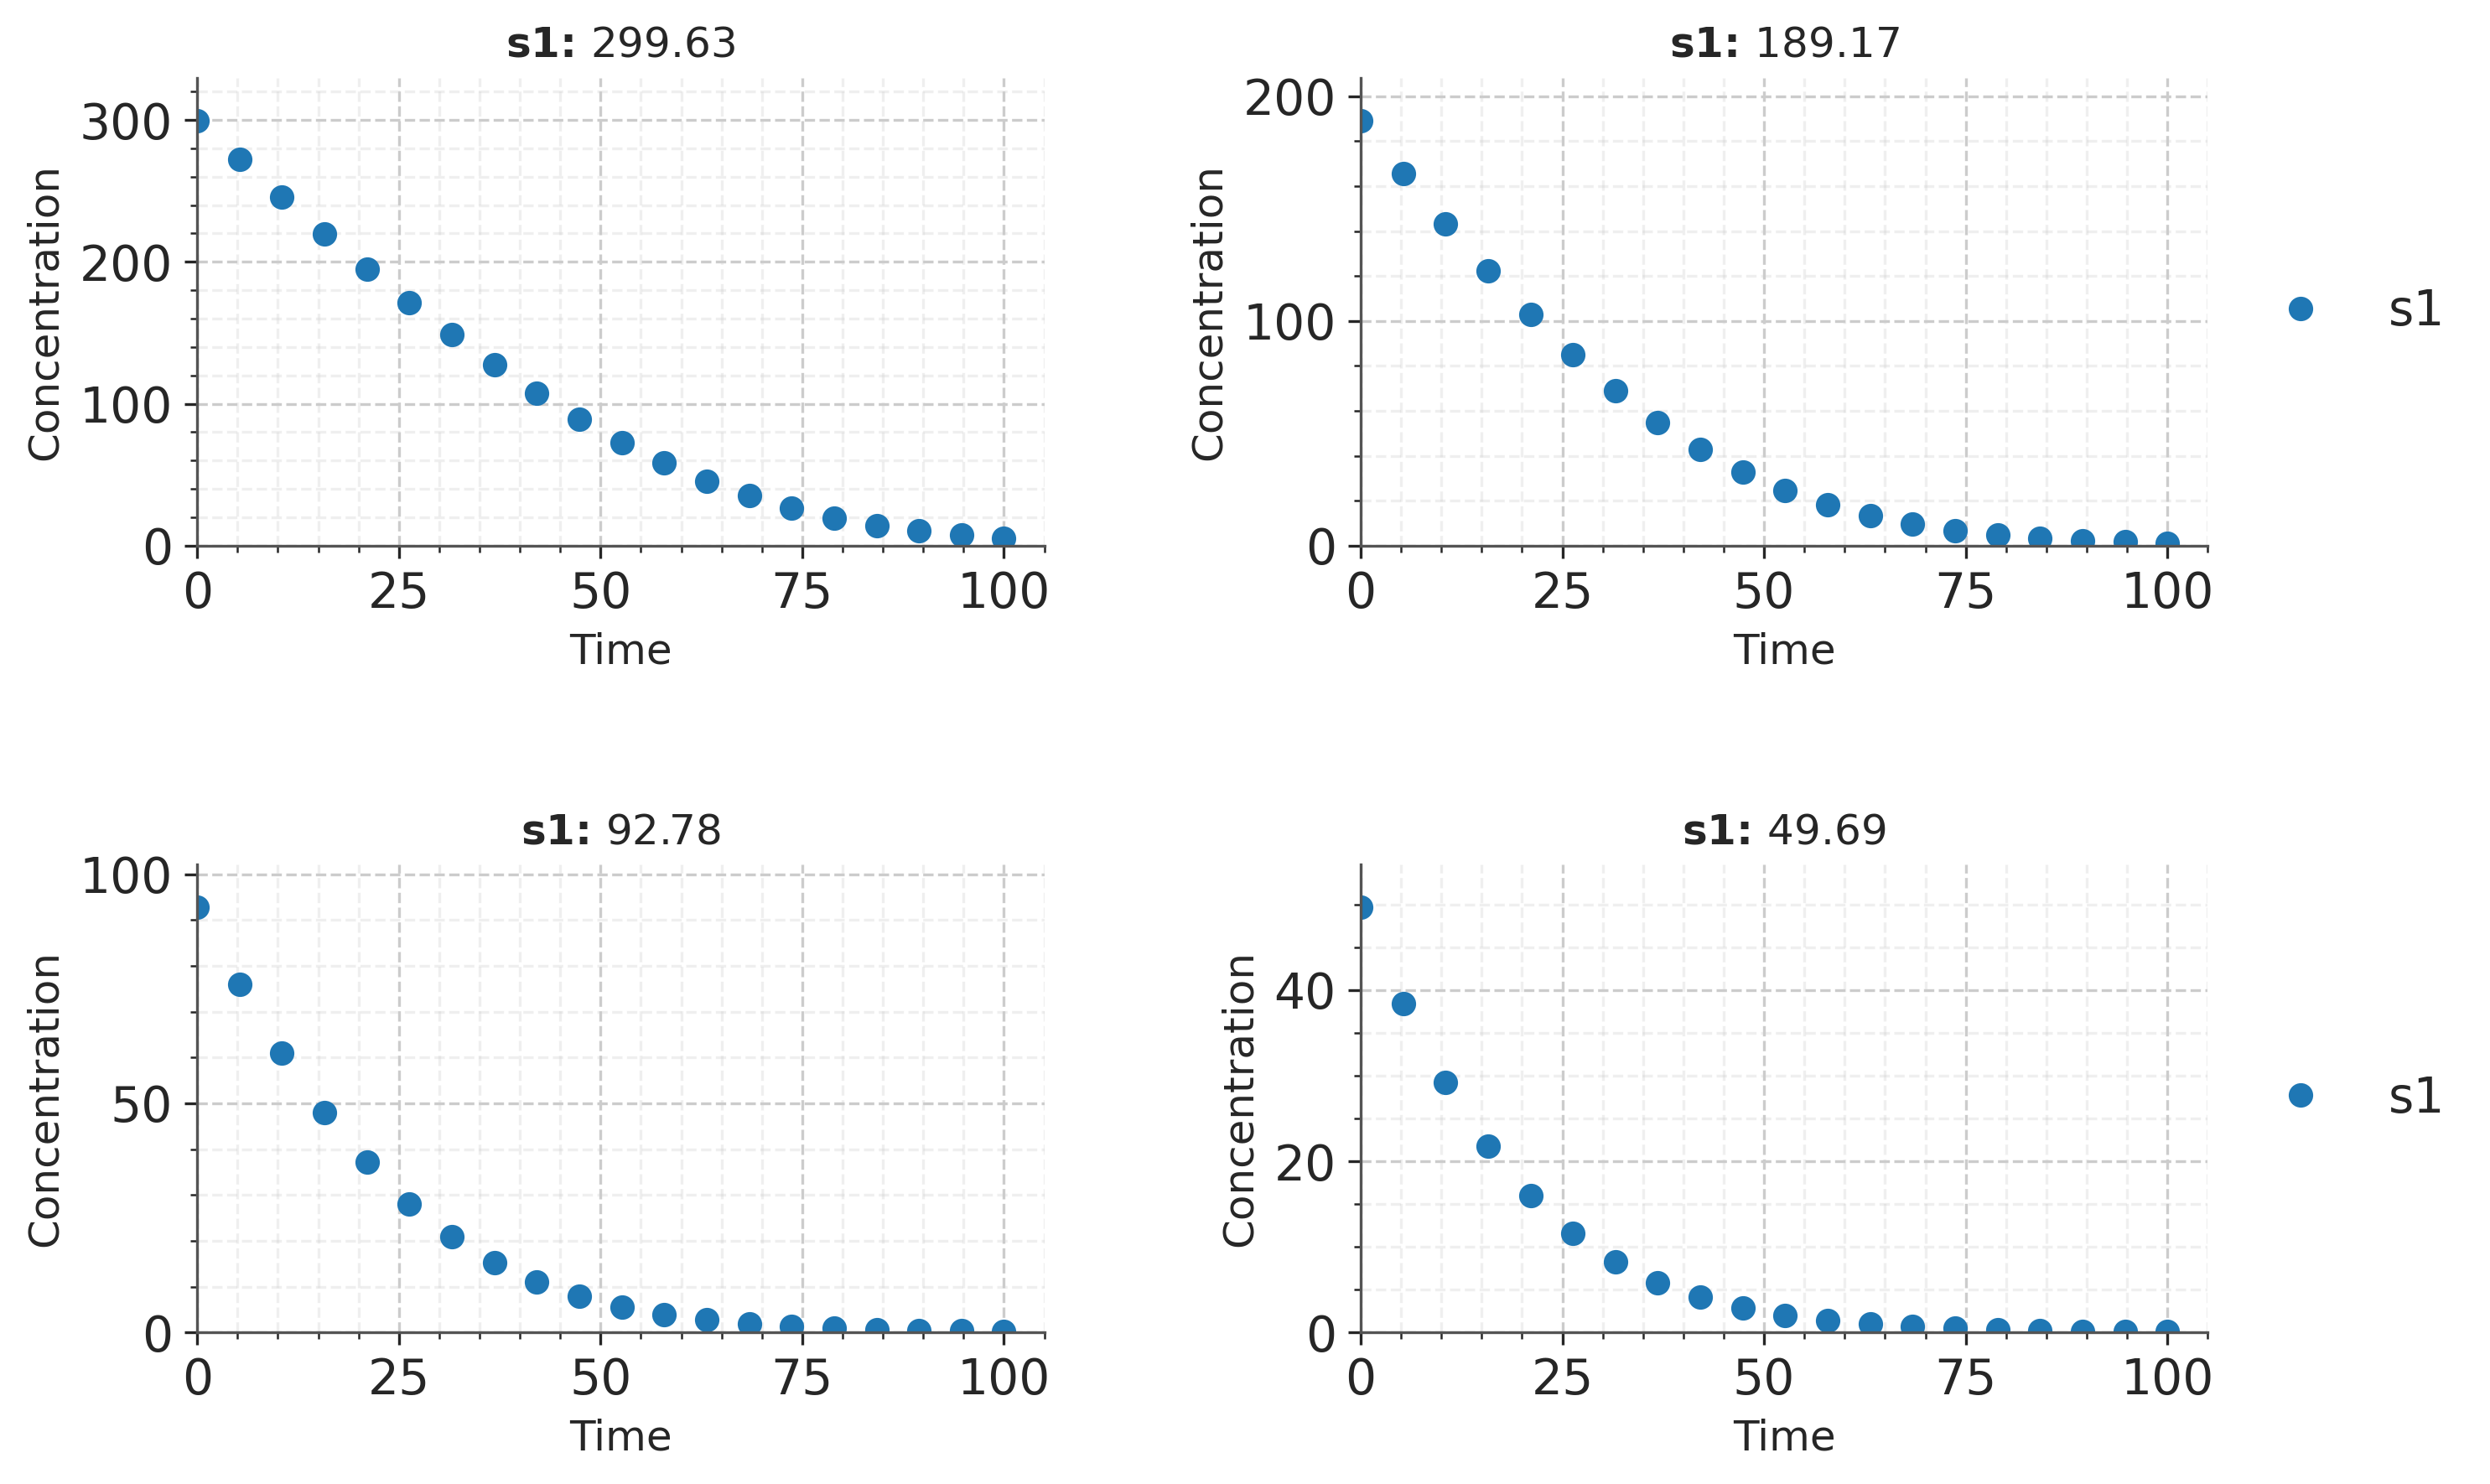

In [4]:
# Load the datasets
dataset = ctx.Dataset.from_croissant("datasets/croissant_dataset.zip")

# Augment the dataset
dataset = dataset.augment(n_augmentations=10, sigma=0.01)

f = dataset.plot(measurement_ids=[m.id for m in dataset.measurements[:4]])

In [5]:
# Create a neural ODE model
neural_ode = ctn.NeuralODE.from_model(
    model,
    width_size=4,
    depth=2,
    activation=jax.nn.celu,
)

# Set up a training strategy (You can interchange the loss function too!)
penalties = ctn.Penalties.for_neural_ode(l2_alpha=1e-5)
strategy = ctn.Strategy(
    penalties=penalties,
    batch_size=20,
)
strategy.add_step(lr=1e-3, length=0.15, steps=1000)
strategy.add_step(lr=1e-3, steps=1000)
strategy.add_step(lr=1e-4, steps=1000)

# Train neural ODE
trained = neural_ode.train(
    dataset=dataset,
    strategy=strategy,
    print_every=10,
    weight_scale=1e-6,
    save_milestones=False,  # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)


🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 20
├── length: 15.0%
├── train: mlp
│


╰── loss: 2.6777 mae: 1.7244: : 1010it [00:08, 112.47it/s]                        




🔸 Step #2
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── train: mlp
│


╰── loss: 0.7189 mae: 0.8114: : 1010it [00:11, 86.82it/s]                         




🔸 Step #3
├── lr: 0.0001
├── batch size: 20
├── length: 100.0%
├── train: mlp
│


╰── loss: 0.6003 mae: 0.7209: : 1010it [00:07, 130.53it/s]                        

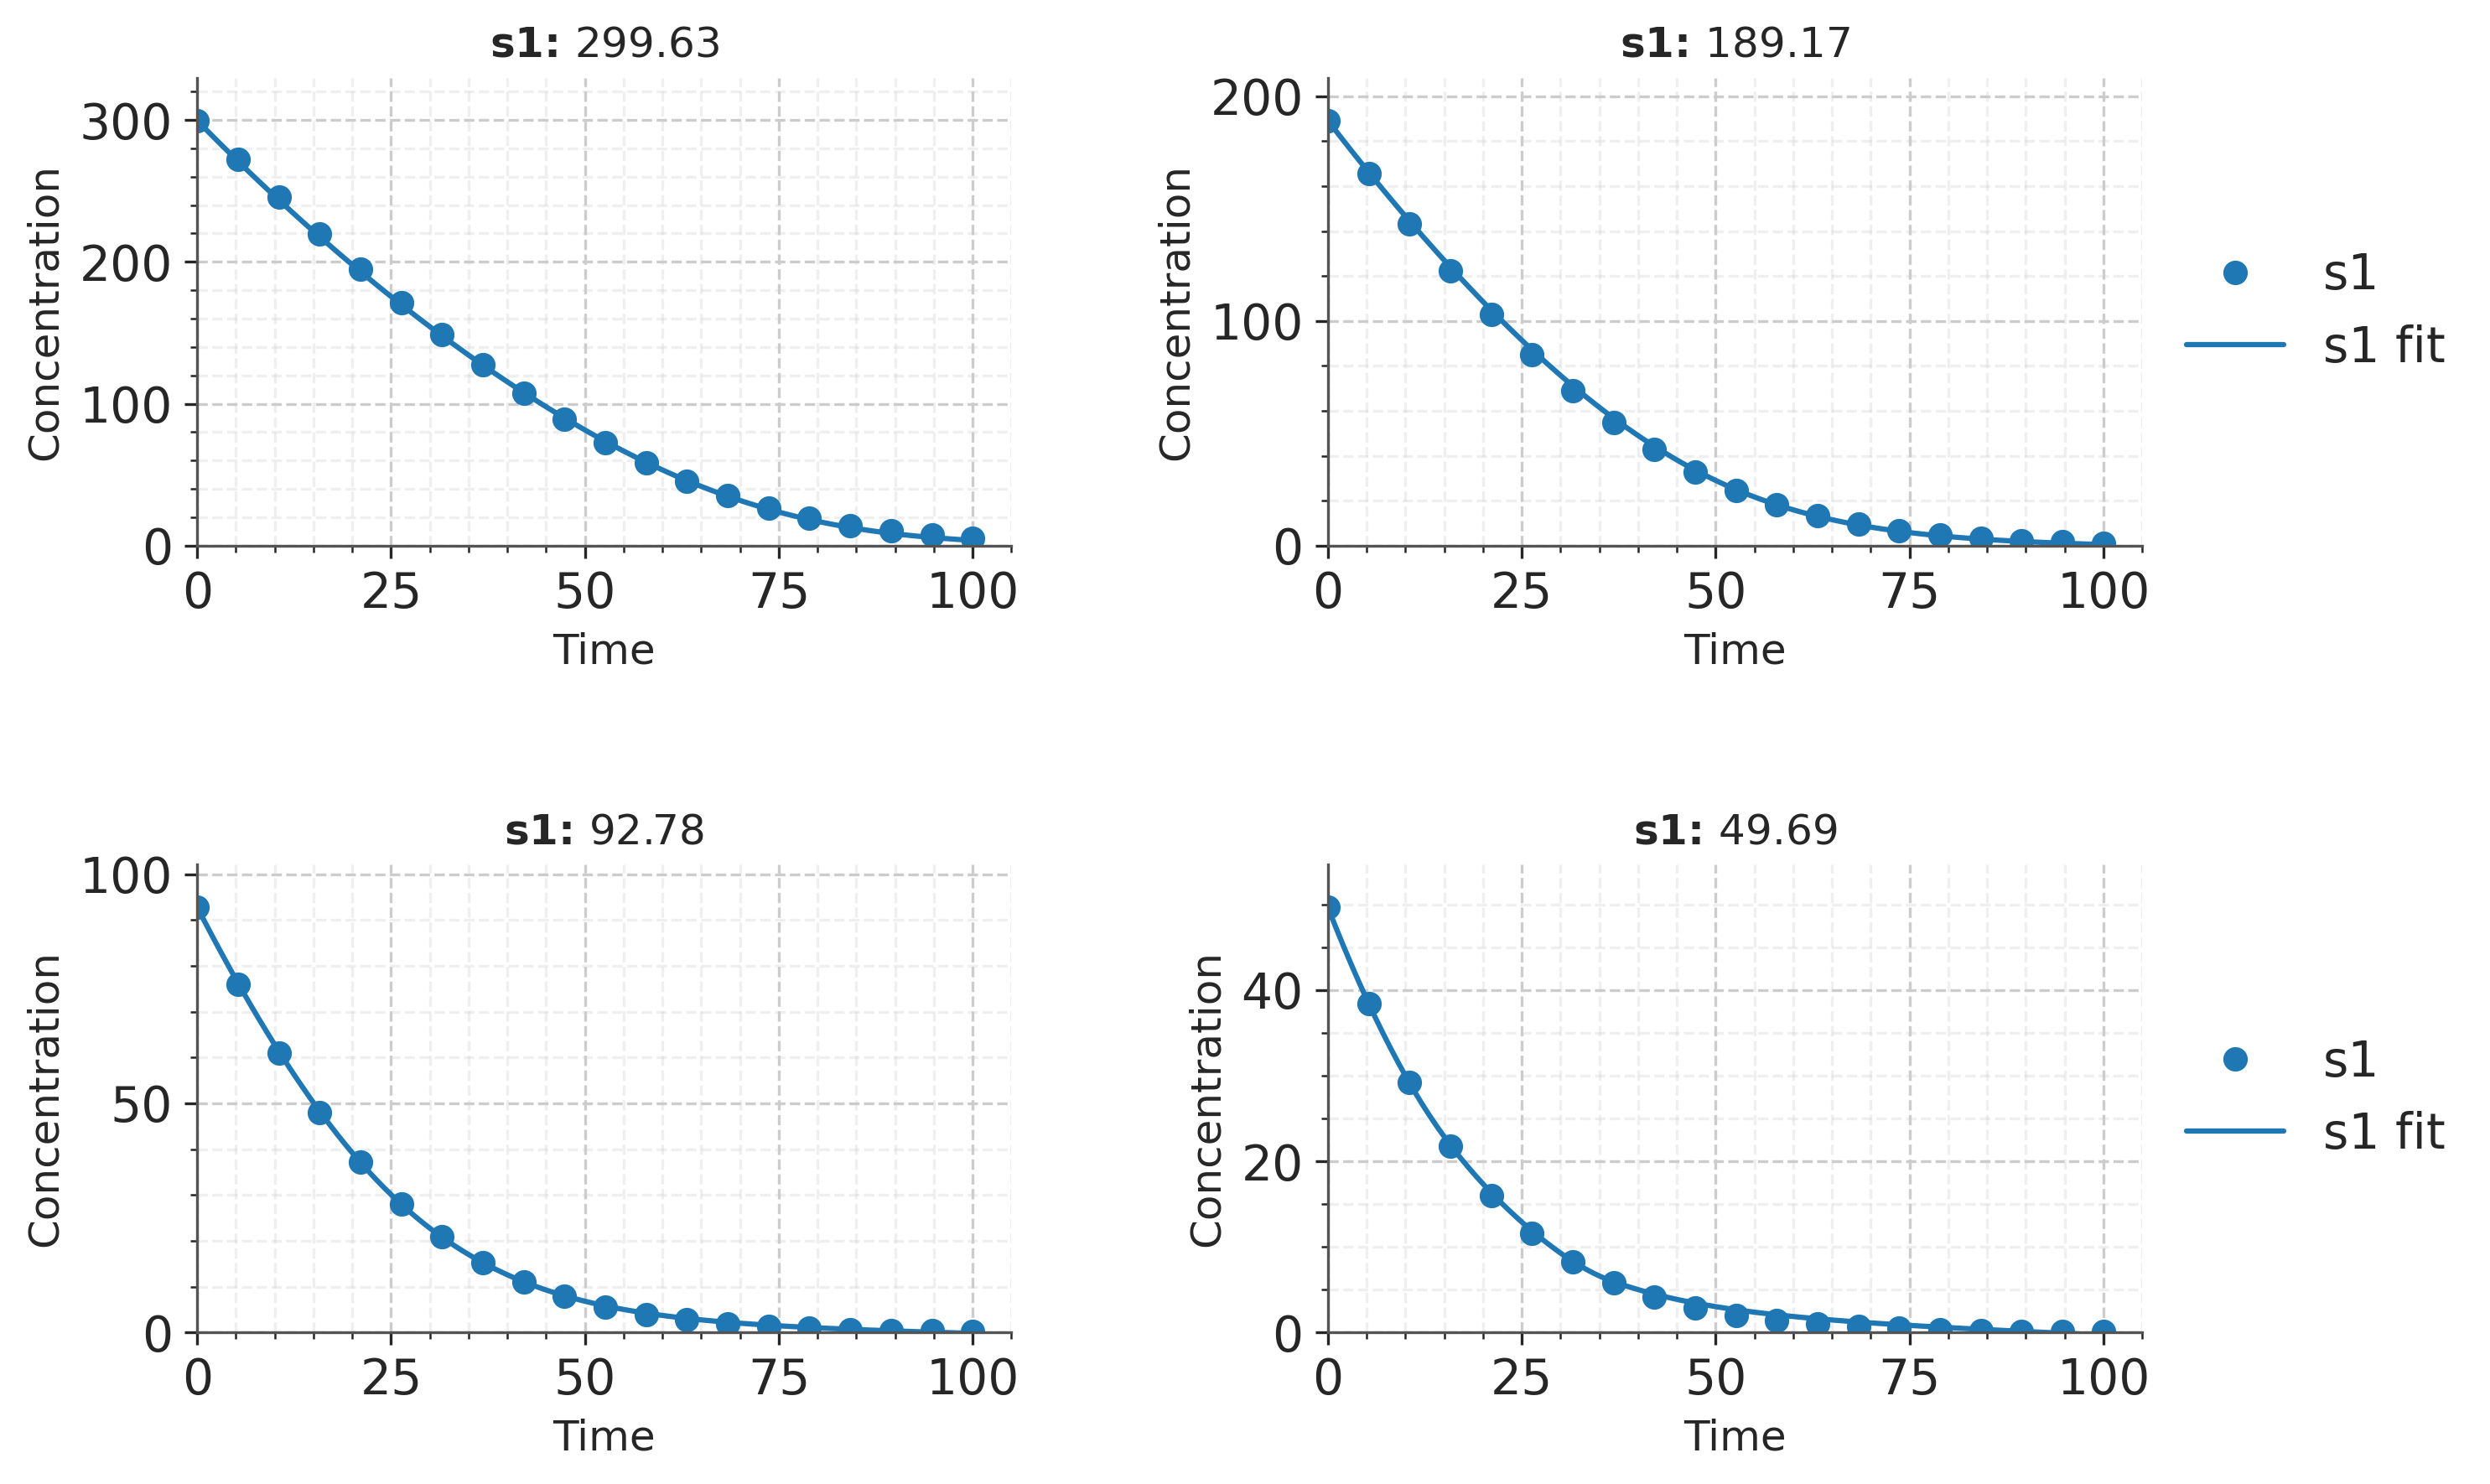

In [6]:
# We can now visualize the fit of the neural ODE to the data
# Please note, a NeuralODE is a subclass of the Predictor class,
# which means it can be used as a predictor in the Dataset.plot method.
f = dataset.plot(
    predictor=trained,
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=False,
)

In [7]:
# Save model
trained.save_to_eqx("./trained/", "menten_trained")